In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

from pathlib import Path
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
)

In [10]:
rng = np.random.default_rng()

In [11]:
def parse_process_group(group):
    """helper function to read stuff out of our hdf5 data structures
    return weight, x_tst, f_tst, cov_f_f, (xlabel, flabel), (poly_degree, sigma, length_scale, sigma_obs)
    """
    attrs = group.attrs
    weight = attrs['weight']

    xlabel = attrs['xlabel']
    if not isinstance(xlabel, str): ### check for compatibility issues between Python 2 and 3...
        xlabel = xlabel.astype(str)

    flabel = attrs['flabel']
    if not isinstance(flabel, str):
        flabel = flabel.astype(str)

    poly_degree = attrs['poly_degree']
    sigma = attrs['sigma']
    length_scale = attrs['length_scale']
    sigma_obs = attrs['sigma_obs']
    m = attrs['model_multiplier'] if ('model_multiplier' in attrs.keys()) else None

    x_tst = group['mean'][xlabel]
    f_tst = group['mean'][flabel]

    cov_f_f = group['cov'][...]

    return weight, x_tst, f_tst, cov_f_f, (xlabel, flabel), (poly_degree, sigma, length_scale, sigma_obs, m)

In [12]:
labels = [
    'cusaagn',
    'cusbagn',
    'cuscagn',
    'cusdagn',
    'cuseagn',
    'cusfagn',
    'cusgagn',
    'cushagn',
    'cusiagn',
    'cusjagn',
    'cuskagn',
    'cuslagn',
    'cusmagn',
    'cusnagn',
    'cusoagn',
    'cuspagn',
    'cusqagn',
    'cusragn',
    'cussagn',
    'custagn',
]

In [13]:
# dest_set_number = 25 (before renaming)
dest_set = Path(f'../data/eos-draws-modified/gp2')
dest_set.mkdir(parents=True, exist_ok=True)

In [14]:
# These are 1000 pQCD-consistent EOS draws from gp1
mean_data = np.loadtxt(dest_set / 'means.dat')

In [15]:
x_star = mean_data[:,0]

In [16]:
means = mean_data[:,1:].T

In [17]:
# Hyperparameters for the square exponential kernel. See 
# inspect_hyperparameters.ipynb.
se_hyperparameters = pd.read_csv(
    '../data/eos-draws-modified/gp2/hyperparams-mc_custom-agnostic.csv'
)

In [18]:
se_hyperparameters_sample = se_hyperparameters.sample(n=1000, replace=False)

In [19]:
se_hyperparameters_sample

poly_degree     sigma         l  sigma_obs  multiplier  logLike
978          3.0  1.130535  0.583458  14.910607    0.384247     -0.0
345          3.0  2.249425  0.194943   8.532194    1.924250     -0.0
641          5.0  1.199585  0.303694   3.594192    4.292341     -0.0
873          3.0  1.166644  0.230292  12.816484    4.305614     -0.0
362          5.0  1.027814  0.804487   9.103974    0.592477     -0.0
..           ...       ...       ...        ...         ...      ...
644          5.0  1.705639  0.870620   4.390974    7.312513     -0.0
78           5.0  1.866599  0.276209   0.906980    3.531375     -0.0
745          3.0  1.067461  0.381570   4.272976    0.637912     -0.0
676          5.0  4.334223  0.716865  19.526448    0.989119     -0.0
329          4.0  1.724937  0.294291  16.462932    8.018355      0.0

[1000 rows x 6 columns]

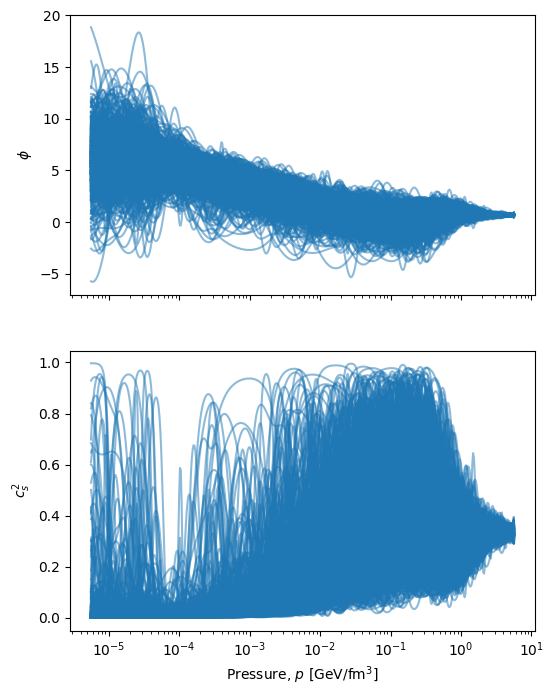

In [20]:
plot = True

if plot:

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
    axs[0].set_xscale('log')

    for phi in means:
            
        axs[0].plot(
            to_GeV_per_cubic_femtometre(np.exp(x_star)), 
            phi, 
            c='C0',
            alpha=0.5
        )
        axs[1].plot(
            to_GeV_per_cubic_femtometre(np.exp(x_star)), 
            1/(1+np.exp(phi)), 
            c='C0',
            alpha=0.5
        )

axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'$\phi$')
axs[1].set_ylabel(r'$c_s^2$');

So we have our means and corresponding hyperparameters. I want to create a new kernel (square exponential) for each using the relevant hyperparameters. Then, instead of conditioning (which changes the mean), I am instead going to apply a scaling to the kernel so that we follow the desired behaviour at low and high pressures.

In [21]:
def kSE(x, xp, sigma, ell):
    return sigma**2*np.exp(-(x-xp)**2/(2*ell**2))

In [22]:
def scaling(x, x_ref, n_scale, sigma_scale=0):
    return sigma_scale + (1-sigma_scale)/(1+(x_ref/x)**n_scale)

In [23]:
load_hyperparams = True

if load_hyperparams:

    scaling_hyperparams_df = pd.read_csv(dest_set / 'scaling_hyperparameters.csv')

    x_ref_low_sample = scaling_hyperparams_df['x_ref_low'].values
    n_scale_low_sample = scaling_hyperparams_df['n_scale_low'].values
    x_ref_high_sample = scaling_hyperparams_df['x_ref_high'].values
    n_scale_high_sample = scaling_hyperparams_df['n_scale_high'].values
    sigma_scale_high_sample = scaling_hyperparams_df['sigma_scale_high'].values

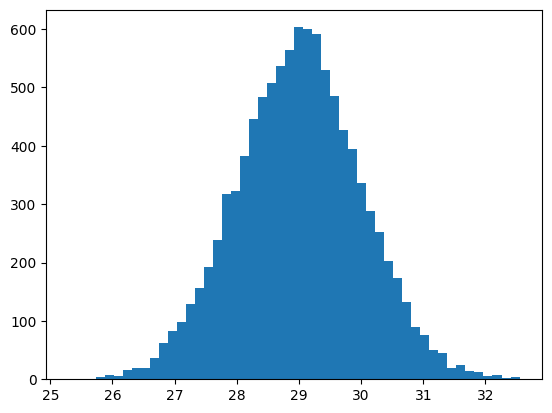

In [ ]:
if not load_hyperparams:
    x_ref_low_sample = rng.normal(loc=29, scale=1, size=1000)

fig, ax = plt.subplots()
ax.hist(x_ref_low_sample);

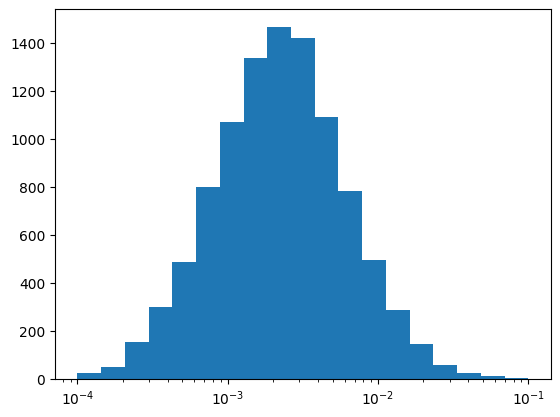

In [46]:
fig, ax = plt.subplots()
ax.set_xscale('log')
bins = np.logspace(-4, -1, num=20)
ax.hist(to_GeV_per_cubic_femtometre(np.exp(x_ref_low_sample)), bins=bins);

In [36]:
def normal(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(1/2)*((x-mu)/sigma)**2)

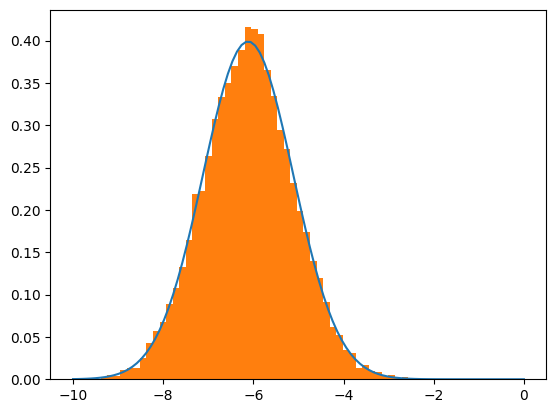

In [44]:
fig, ax = plt.subplots()
x = np.linspace(-10, 0, num=100)
ax.plot(x, normal(x, np.log(to_GeV_per_cubic_femtometre(np.exp(29))), 1))
ax.hist(np.log(to_GeV_per_cubic_femtometre(np.exp(x_ref_low_sample))), density=True, bins=50);

In [40]:
to_GeV_per_cubic_femtometre(np.exp(29))

0.0022053168071004808

In [8]:
to_GeV_per_cubic_femtometre(np.exp(1))

1.5248442766852589e-15

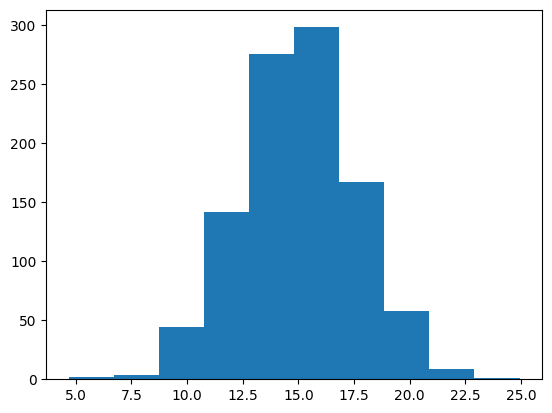

In [20]:
if not load_hyperparams:
    n_scale_low_sample = rng.normal(loc=15, scale=2.5, size=1000)

fig, ax = plt.subplots()
ax.hist(n_scale_low_sample);

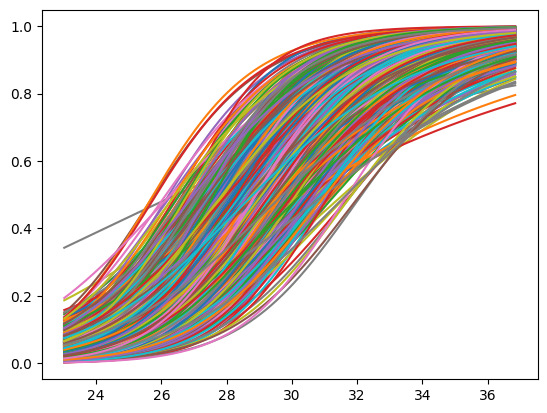

In [21]:
fig, ax = plt.subplots()

for x_ref, n_scale in zip(x_ref_low_sample, n_scale_low_sample):
    ax.plot(x_star, scaling(x_star, x_ref=x_ref, n_scale=n_scale))

In [22]:
def stitch(x, x_ref, n_stitch, sigma_stitch):
    return sigma_stitch**2*np.exp(n_stitch*(x-x_ref))

In [29]:
x_stitch = np.linspace(np.log(1e14), np.log(1e16), num=100)

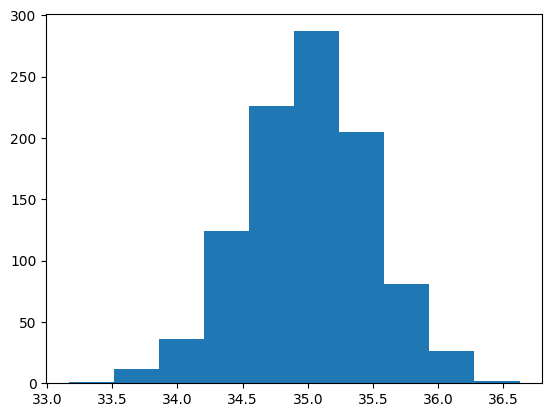

In [28]:
if not load_hyperparams:
    x_ref_high_sample = rng.normal(loc=35, scale=0.5, size=1000)

fig, ax = plt.subplots()
ax.hist(x_ref_high_sample);

In [45]:
to_GeV_per_cubic_femtometre(np.exp(35))

0.8896882987577979

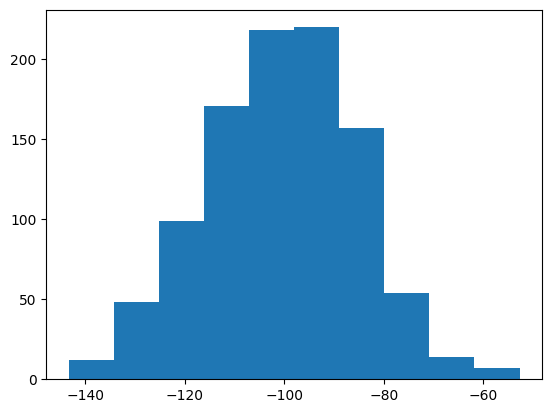

In [30]:
if not load_hyperparams:    
    n_scale_high_sample = rng.normal(loc=-100, scale=15, size=1000)

fig, ax = plt.subplots()
ax.hist(n_scale_high_sample);

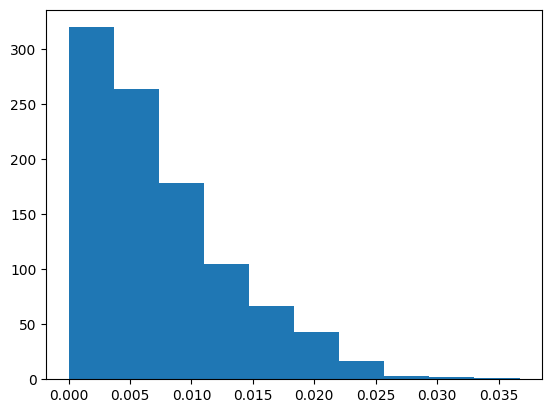

In [31]:
if not load_hyperparams:
    sigma_scale_high_sample = abs(rng.normal(loc=0., scale=0.01, size=1000))

fig, ax = plt.subplots()
ax.hist(sigma_scale_high_sample);

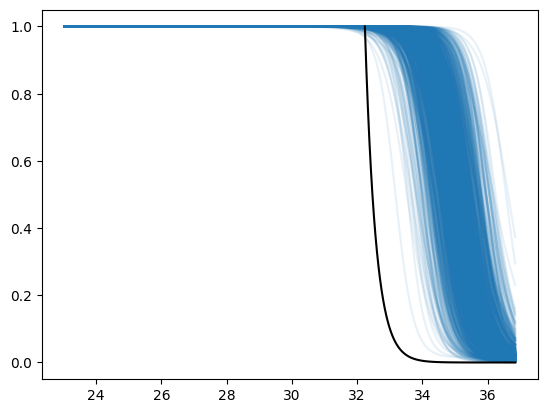

In [32]:
fig, ax = plt.subplots()
ax.plot(
    x_stitch, 
    stitch(x_stitch, x_ref=np.log(1e16), n_stitch=-3, sigma_stitch=0.1)/max(stitch(x_stitch, x_ref=np.log(1e16), n_stitch=-3, sigma_stitch=0.1)), 
    zorder=10, 
    c='k'
)

for x_ref, n_scale, sigma_scale in zip(x_ref_high_sample, n_scale_high_sample, sigma_scale_high_sample):
    ax.plot(
        x_star, 
        scaling(x_star, x_ref=x_ref, n_scale=n_scale, sigma_scale=sigma_scale), 
        c='C0', 
        alpha=0.1
    )

In [35]:
covs = []

for label_count, label in enumerate(labels):
    for model_count in range(50):

        index = 50*label_count + model_count

        mean = means[index]

        sigma = se_hyperparameters_sample.iloc[index]['sigma']
        ell = se_hyperparameters_sample.iloc[index]['l']

        x_ref_low = x_ref_low_sample[index]
        n_scale_low = n_scale_low_sample[index]
        x_ref_high = x_ref_high_sample[index]
        n_scale_high = n_scale_high_sample[index]
        sigma_scale_high = sigma_scale_high_sample[index]

        cov = np.zeros((len(x_star), len(x_star)))
        for i, x in enumerate(x_star):
            for j, xp in enumerate(x_star):
                cov[i,j] = kSE(x, xp, sigma=sigma, ell=ell)

        low_scaling_matrix = np.zeros((len(x_star), len(x_star)))
        for i, xi in enumerate(x_star):
            for j, xj in enumerate(x_star):
                low_scaling_matrix[i,j] = \
                    scaling(xi, x_ref=x_ref_low, n_scale=n_scale_low)*scaling(xj, x_ref=x_ref_low, n_scale=n_scale_low)
                
        high_scaling_matrix = np.zeros((len(x_star), len(x_star)))
        for i, xi in enumerate(x_star):
            for j, xj in enumerate(x_star):
                high_scaling_matrix[i,j] = \
                    scaling(
                        xi, 
                        x_ref=x_ref_high, 
                        n_scale=n_scale_high, 
                        sigma_scale=sigma_scale_high
                    ) * \
                    scaling(
                        xj, 
                        x_ref=x_ref_high, 
                        n_scale=n_scale_high, 
                        sigma_scale=sigma_scale_high
                    )
                
        cov *= low_scaling_matrix*high_scaling_matrix
        
        covs.append(cov)

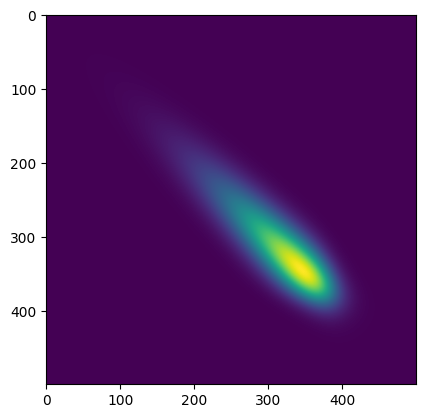

In [36]:
plt.imshow(covs[0]);

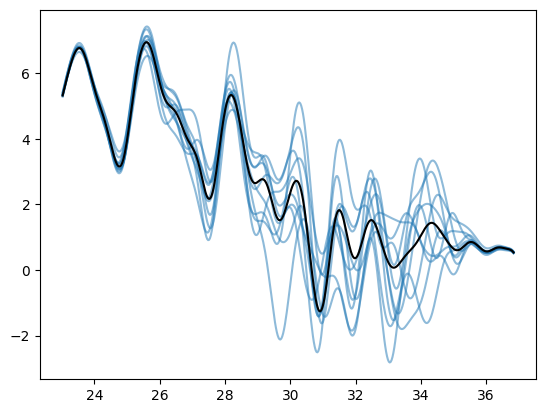

In [ ]:
fig, ax = plt.subplots()

n = 50

ax.plot(x_star, means[n], c='k', zorder=5)

repeats = 10
for _ in range(repeats):
    ax.plot(
        x_star, 
        rng.multivariate_normal(means[n], covs[n]), 
        alpha=0.5, 
        c='C0'
        )

In [48]:
from universality.gaussianprocess import gaussianprocess as gp

In [60]:
for label_count, label in enumerate(labels):

    dest_dir = dest_set / label
    dest_dir.mkdir(parents=True, exist_ok=True)

    dest_file = dest_dir / f'gpr_gpr_{label}.hdf5'

    with h5py.File(dest_file, 'w') as obj:

        for model_count in range(50):

            index = 50*label_count + model_count

            phi = means[index]
            cov = covs[index]

            gp.create_process_group(
                obj.create_group(str(model_count)),
                0,
                0,
                0,
                0,
                x_star,
                phi,
                cov,
                xlabel='log(pressurec2)',
                flabel='phi',
                weight=1/50.,
                model_multiplier=1,
            )

In [62]:
new_mean_dict_verify = {}
new_cov_dict_verify = {}
for label in labels:
    new_mean_dict_verify[label] = {}
    new_cov_dict_verify[label] = {}
    file_path = dest_set / label / f'gpr_gpr_{label}.hdf5'
    with h5py.File(file_path, 'r') as f:
        for model_number in range(50):
            cov = np.array(f[str(model_number)]['cov'])
            mean = np.array(f[str(model_number)]['mean'])
            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])
            new_cov_dict_verify[label][model_number] = cov
            new_mean_dict_verify[label][model_number] = (log_pressure,phi)

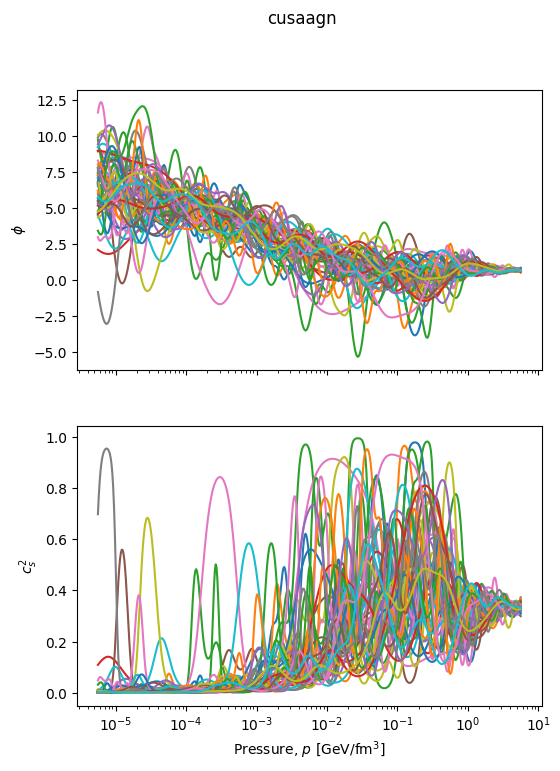

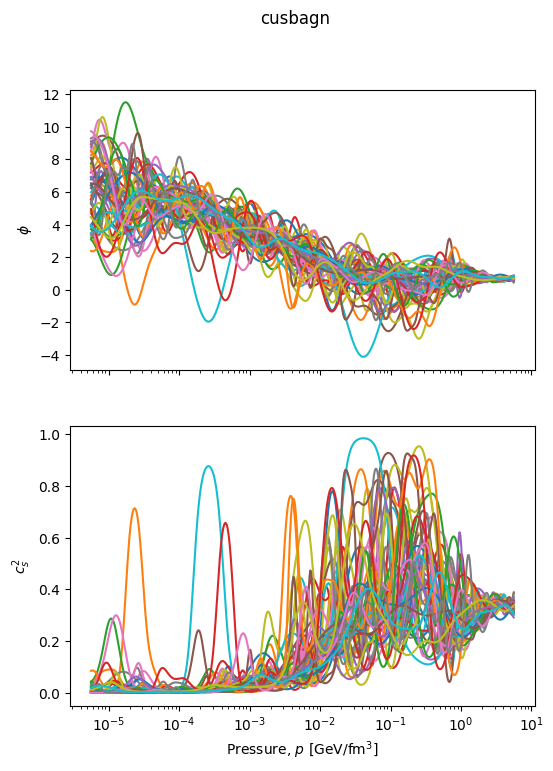

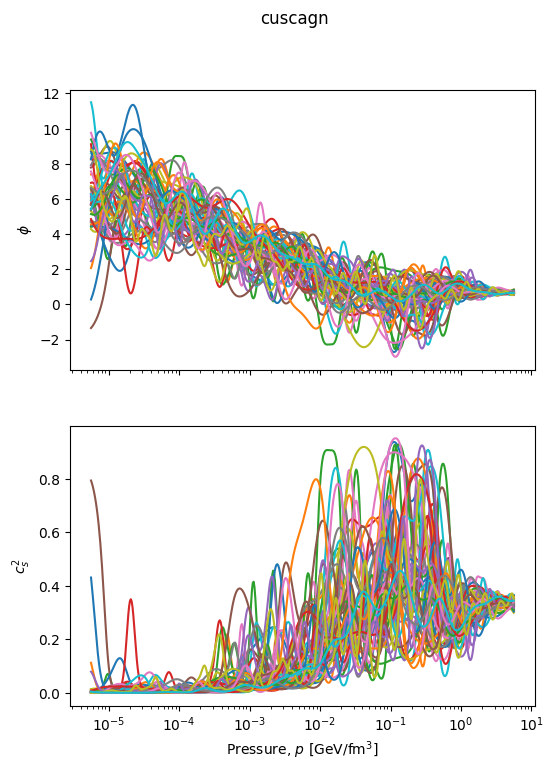

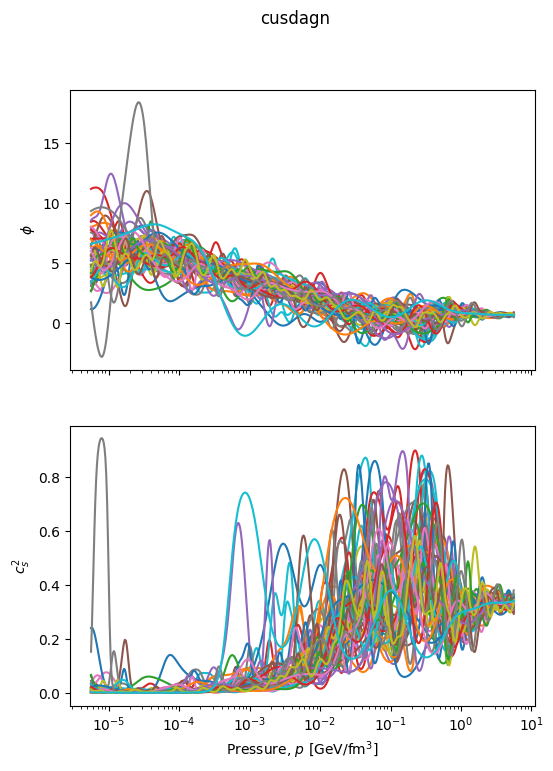

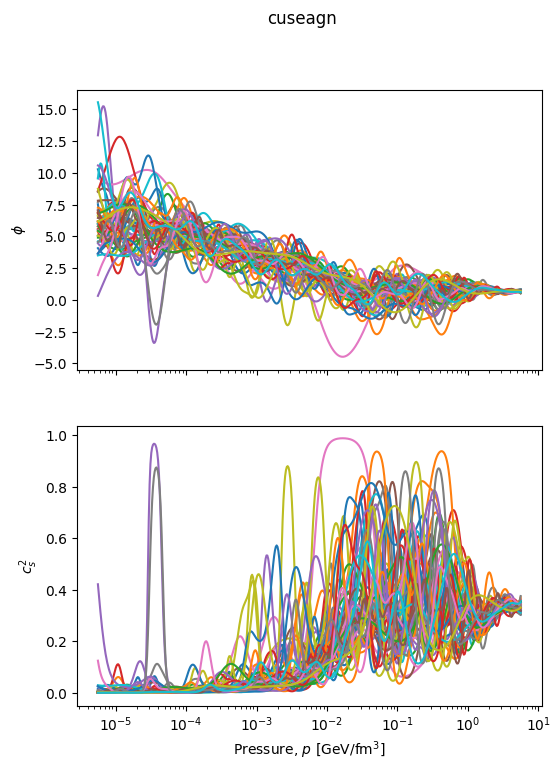

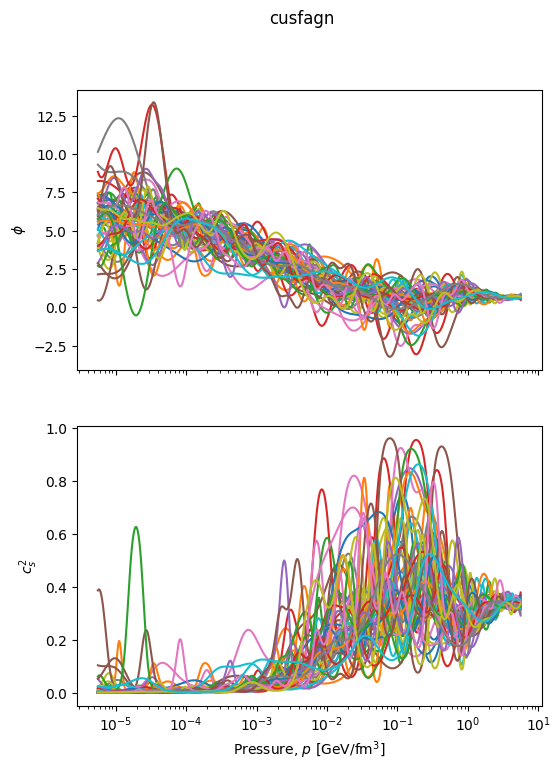

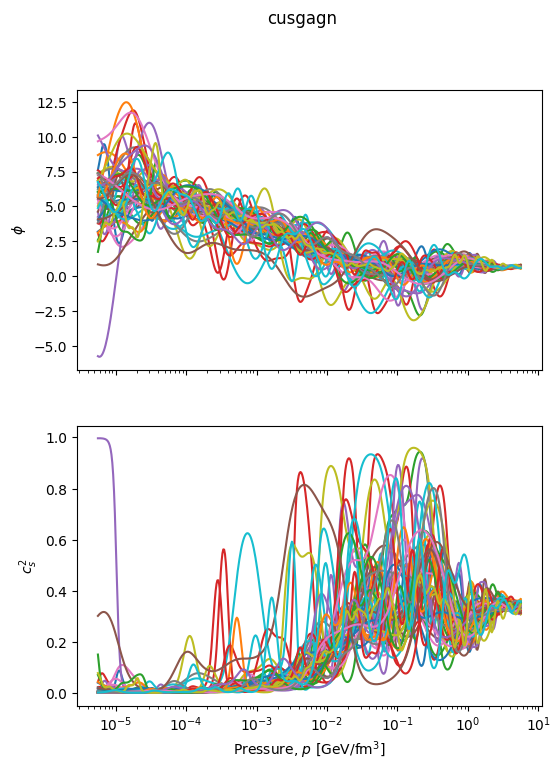

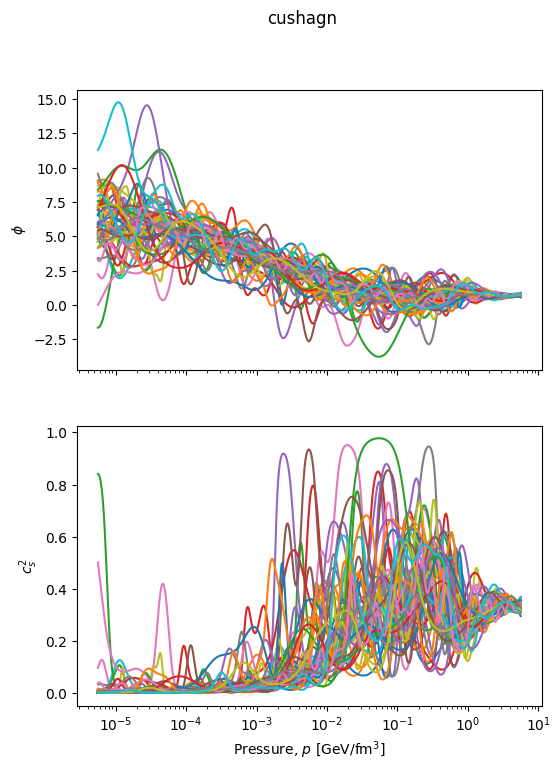

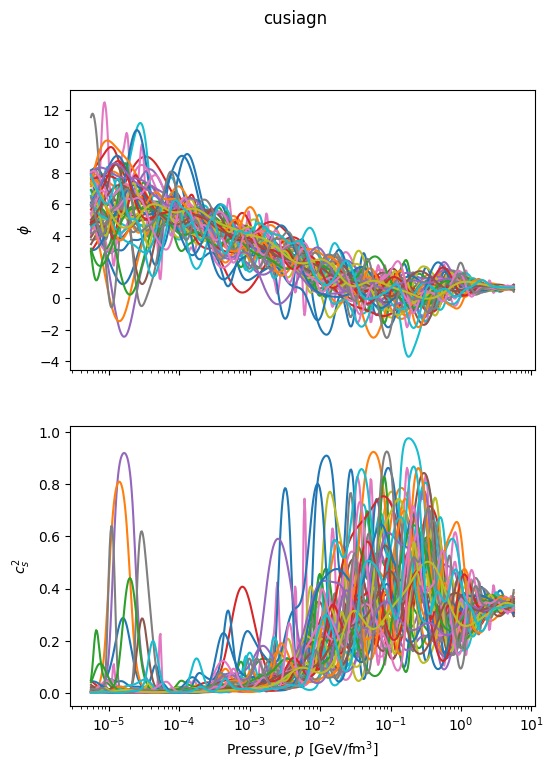

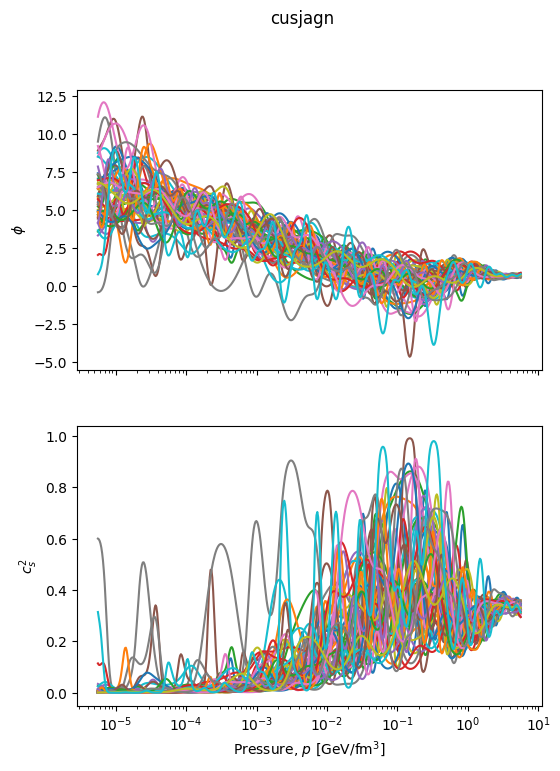

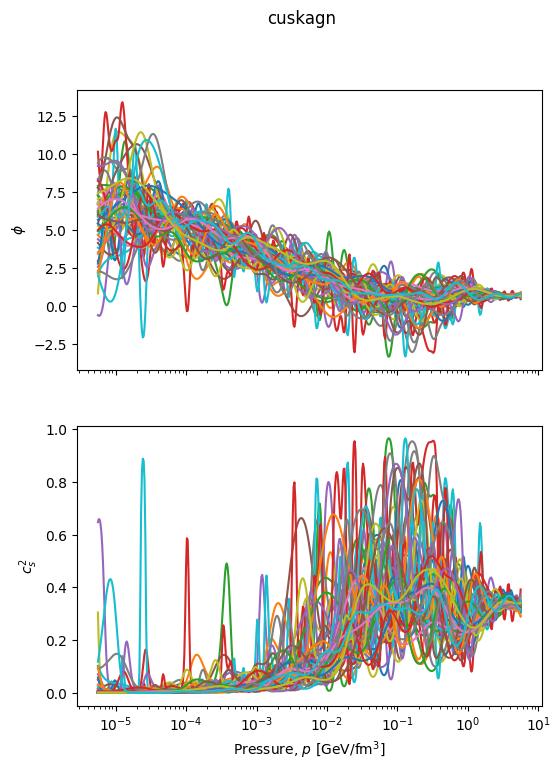

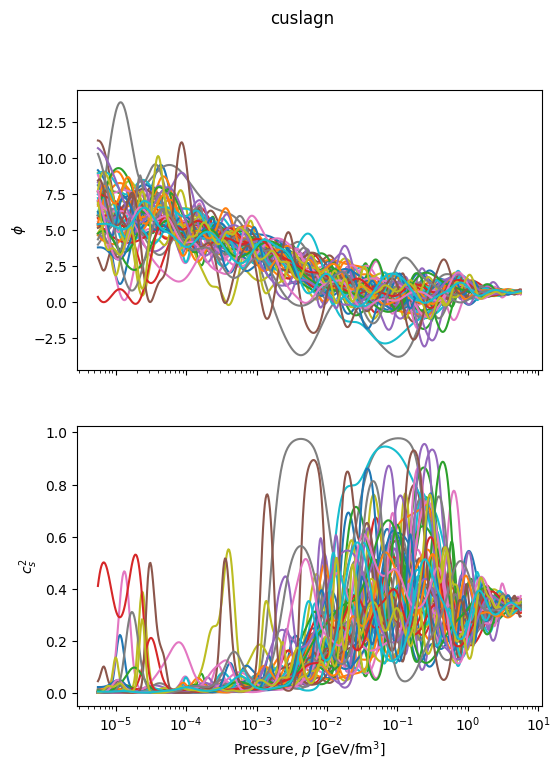

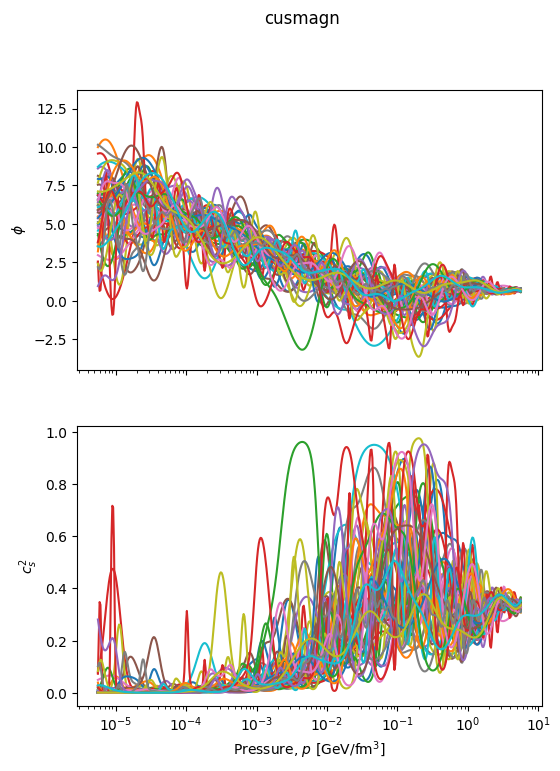

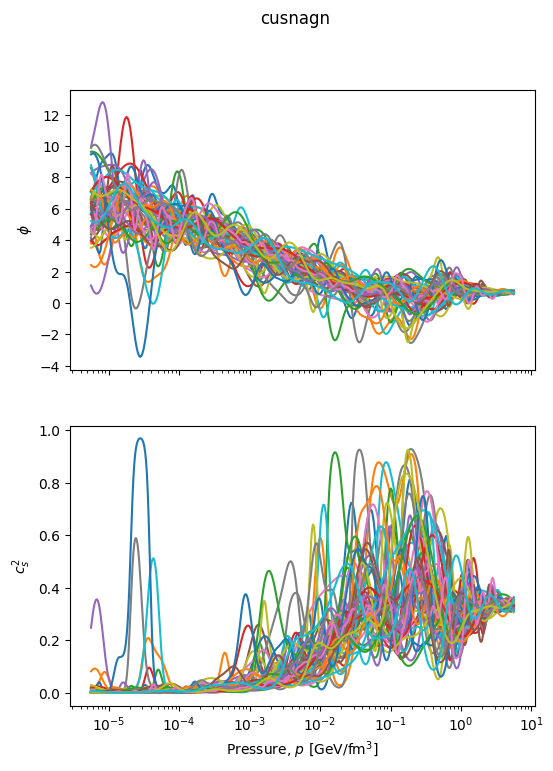

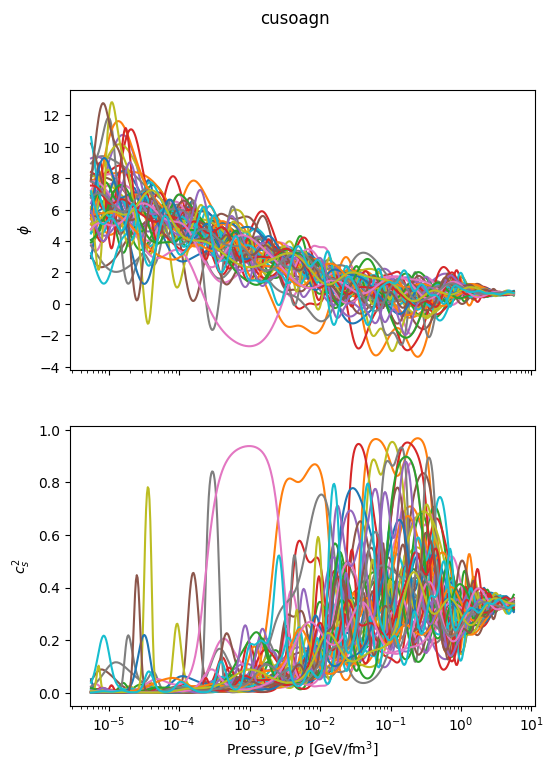

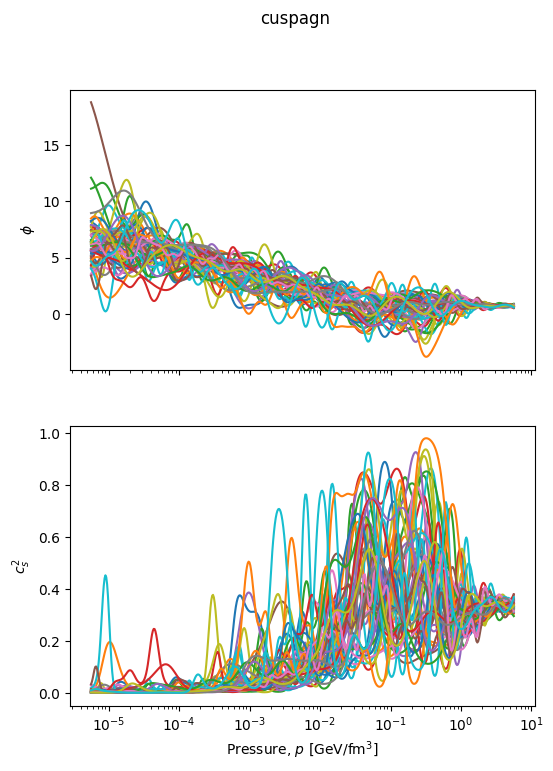

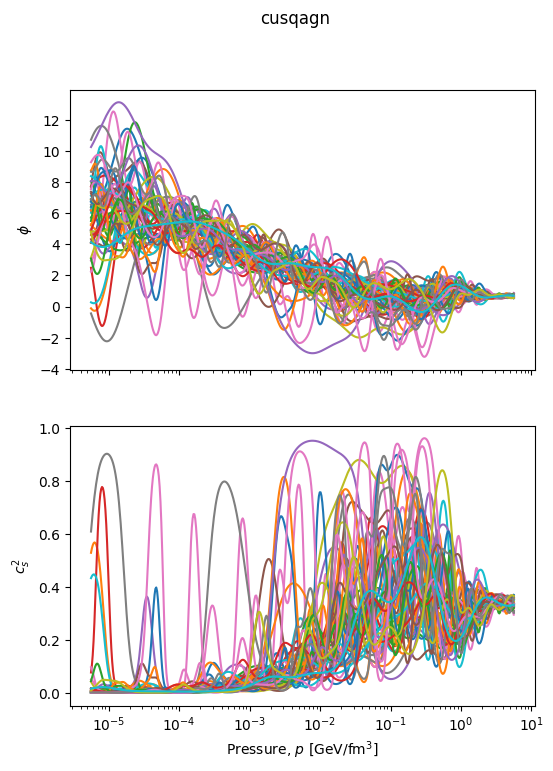

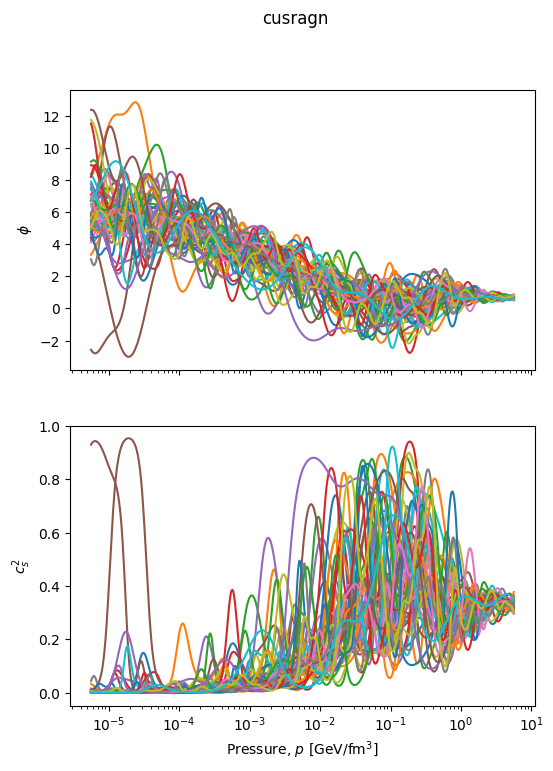

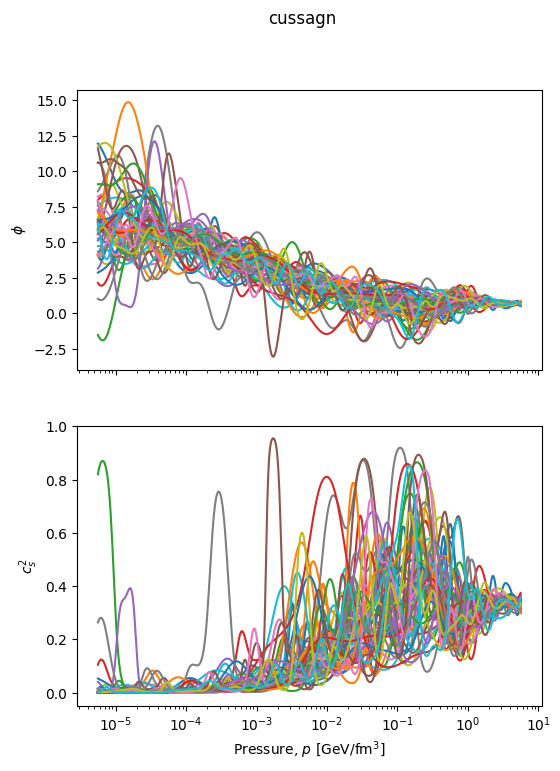

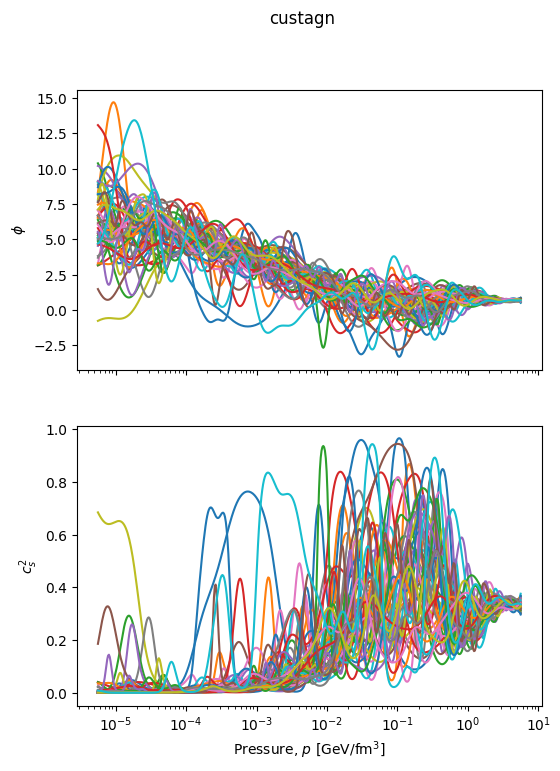

In [63]:
for label in new_mean_dict_verify.keys():

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
    fig.suptitle(label)
    axs[0].set_xscale('log')

    for model_number in range(50):

        log_pressure, phi = new_mean_dict_verify[label][model_number]
        
        axs[0].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            phi, 
        )
        axs[1].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            1/(1+np.exp(phi)), 
        )

    axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
    axs[0].set_ylabel(r'$\phi$')
    axs[1].set_ylabel(r'$c_s^2$');

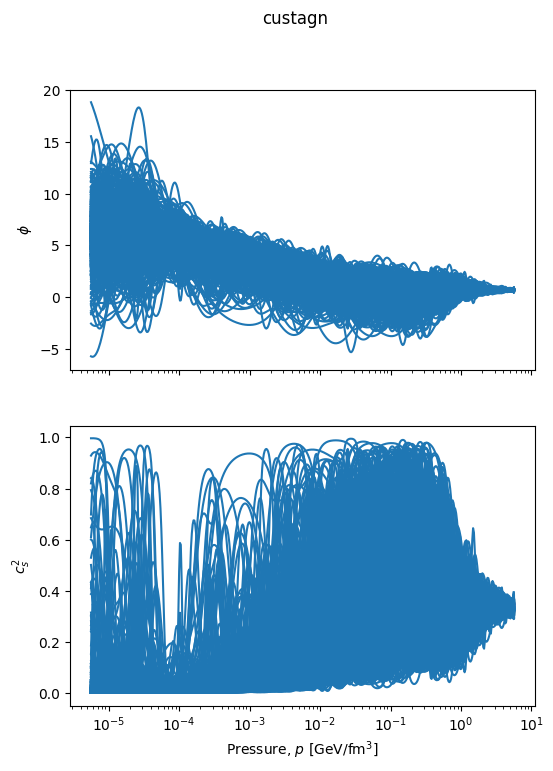

In [64]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
fig.suptitle(label)
axs[0].set_xscale('log')

for label in new_mean_dict_verify.keys():
    for model_number in range(50):

        log_pressure, phi = new_mean_dict_verify[label][model_number]
        
        axs[0].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            phi, 
            c='C0'
        )
        axs[1].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            1/(1+np.exp(phi)), 
            c='C0'
        )

    axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
    axs[0].set_ylabel(r'$\phi$')
    axs[1].set_ylabel(r'$c_s^2$');

In [ ]:
# Determine grid size
num_matrices = len(new_cov_dict_verify)
grid_size = int(np.ceil(np.sqrt(num_matrices)))  # Square grid

# Create subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through the dictionary and display each matrix
model_number = 0

for i, label in enumerate(new_cov_dict_verify.keys()):

    matrix = new_cov_dict_verify[label][model_number]

    im = axs[i].imshow(matrix, cmap='viridis')
    axs[i].set_title(label)
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

# Hide any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

fig.tight_layout()